In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [2]:
models = {
#     "GloVe": "baseline",
#     "ConvS2S": "fairseq.wmt14.en-fr.fconv",
#     "InferSent": "infersent.allnli",
#     "IMDB": "imdbsentiment",
#     "skipthought": "skipthought",
#     "DisSent": "dissent.books8.epoch9",
#     "order": "order-embeddings",
#     "ELMo": "elmo.2x4096",
#     "BERT": "bert.base",
# #     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-MRPC",
#     "BERT-CoLA": "bert.base.finetune-CoLA",
#     "BERT-MNLI": "bert.base.finetune-MNLI",
#     "BERT-RTE": "bert.base.finetune-RTE",
#     "BERT-SST": "bert.base.finetune-SST",
#     "BERT-WNLI": "bert.base.finetune-WNLI",
#     "BERT-QQP": "bert.base.finetune-QQP",
#     "BERT-SNLI": "bert.base.finetune-SNLI",
#     "openai": "transformer.roc",
    
    "BERT": "bert.base",
#     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-5000-MRPC",
#     "BERT-CoLA": "bert.base.finetune-5000-CoLA",
    "BERT-MNLI": "bert.base.finetune-5000-MNLI",
    "BERT-RTE": "bert.base.finetune-5000-RTE",
#     "BERT-SST": "bert.base.finetune-5000-SST",
#     "BERT-WNLI": "bert.base.finetune-5000-WNLI",
    "BERT-QQP": "bert.base.finetune-5000-QQP",
    "BERT-SNLI": "bert.base.finetune-5000-SNLI",
    
    "BERT-MNLIb": "bert.base.finetune-5000-MNLI.concat_with_base",
    "BERT-QQPb": "bert.base.finetune-5000-QQP.concat_with_base",
    "BERT-RTEb": "bert.base.finetune-5000-RTE.concat_with_base",
    "BERT-SNLIb": "bert.base.finetune-5000-SNLI.concat_with_base",
}

In [3]:
stats = {}

--------

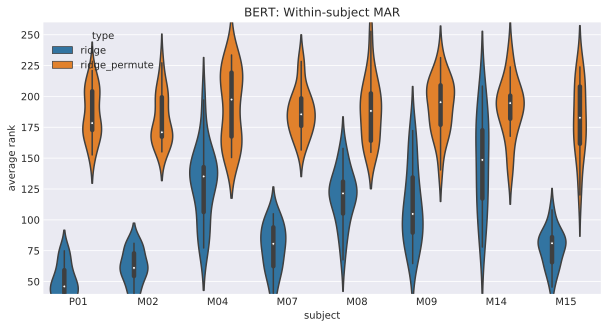

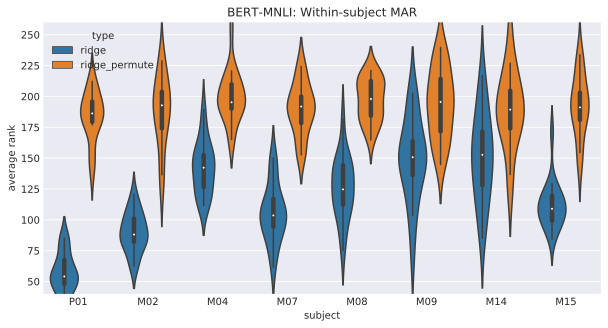

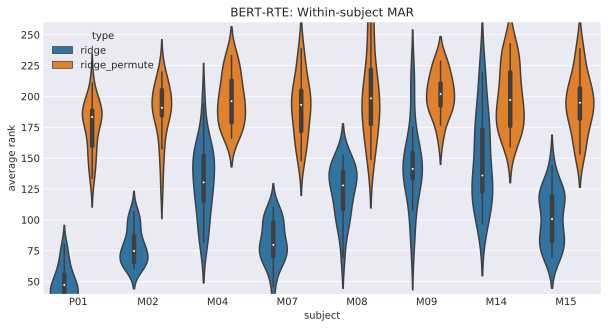

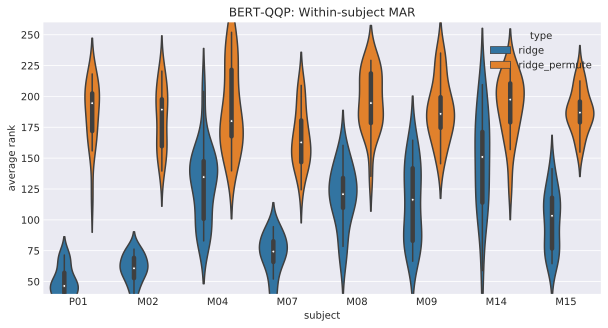

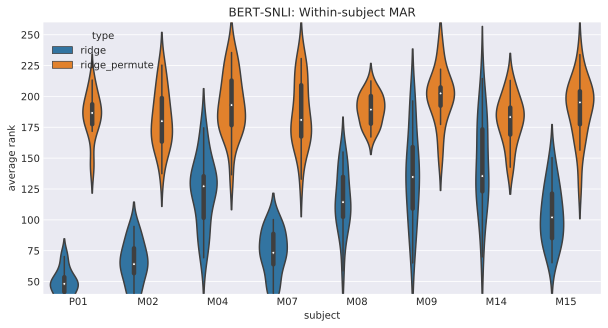

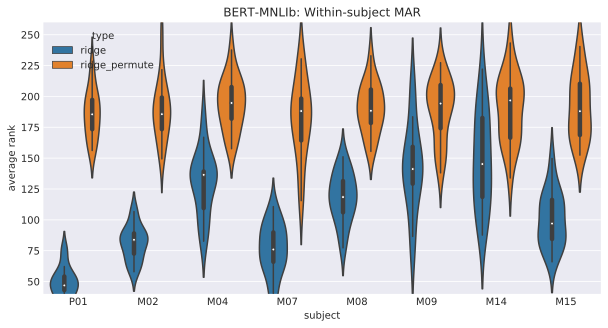

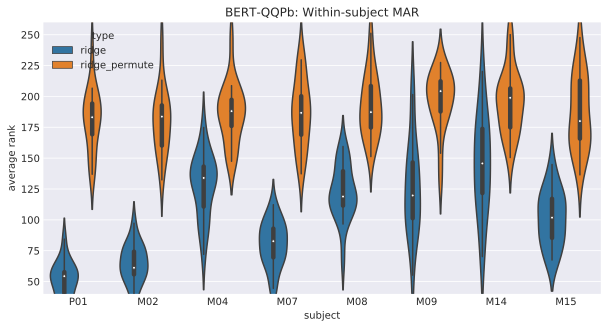

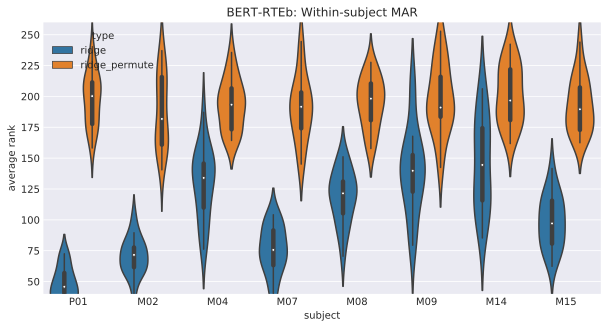

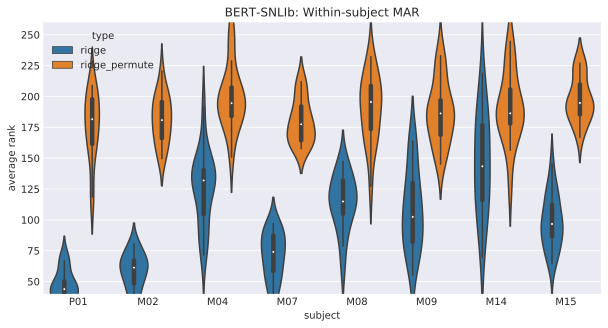

In [19]:
for model, path in models.items():
    f, ax = plt.subplots(figsize=(10,5))
    try:
        stats[model] = util.load_decoding_perf(model, "perf.384sentences.%s.csv" % path, ax=ax)
    except: raise

-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [5]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "subject"]).reset_index()

In [6]:
f.head()

type,target,subject,ridge,ridge_permute
0,BERT,P01,48.703704,185.690476
1,BERT,M02,61.005291,181.613757
2,BERT,M04,129.359788,191.584656
3,BERT,M07,76.989418,187.447090
4,BERT,M08,118.492063,189.187831


In [28]:
pairs = []
for model in models.keys():
    if model + "b" in models.keys():
        pairs.append((model, model + "b"))
wilcoxon_results = util.wilcoxon_rank_preds(models, pairs=pairs)
wilcoxon_results.head()

,,w_stat,p_val,p_val_corrected
model1,model2,,,
BERT-MNLI,BERT-MNLIb,1661878.0,5.118726e-30,1.279682e-30
BERT-RTE,BERT-RTEb,1852114.5,1.756267e-11,4.390667e-12
BERT-QQP,BERT-QQPb,2013413.0,1.034950e-03,2.587375e-04
BERT-SNLI,BERT-SNLIb,1880938.5,3.716591e-09,9.291478e-10


In [29]:
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val_corrected"] < 0.01
wilcoxon_results.sort_values("p_val")

,,w_stat,p_val,p_val_corrected,significant_bonferroni
model1,model2,,,,
BERT-MNLI,BERT-MNLIb,1661878.0,5.118726e-30,1.279682e-30,True
BERT-RTE,BERT-RTEb,1852114.5,1.756267e-11,4.390667e-12,True
BERT-SNLI,BERT-SNLIb,1880938.5,3.716591e-09,9.291478e-10,True
BERT-QQP,BERT-QQPb,2013413.0,1.034950e-03,2.587375e-04,True


---------

# Aggregate graphs

## Decoding analysis

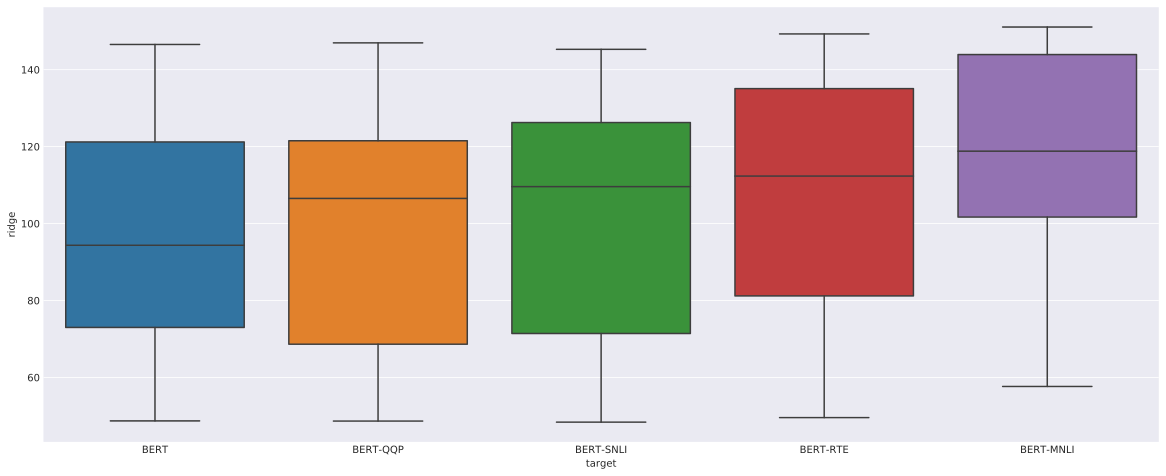

In [10]:
fig, ax = plt.subplots(figsize=(20, 8))

f_sub = f[~f.target.str.endswith("b")]
target_order = f_sub.groupby("target").ridge.agg("mean").argsort()
sns.boxplot(x="target", y="ridge", data=f_sub, ax=ax, order=target_order.index[target_order])

In [11]:
f_sub.groupby("target").ridge.agg("mean")

target
BERT          96.226190
BERT-MNLI    116.659061
BERT-QQP      98.552249
BERT-RTE     107.514550
BERT-SNLI    101.234458
Name: ridge, dtype: float64

[-0.4  0.6  1.6  2.6  3.6  0. ]


Text(0.87,-0.07,'* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test')

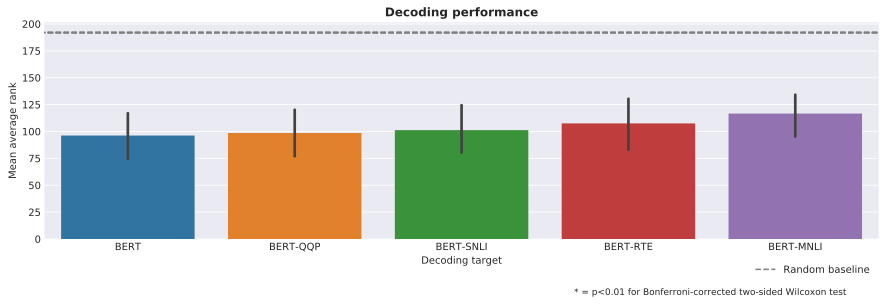

In [12]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f_sub)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.08))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
xticks = {label.get_text(): (pos, label) for pos, label in xticks}
mean_results = f.groupby("target").ridge.agg("mean")
# for (m1_pos, m1_label), (m2_pos, m2_label) in zip(xticks, xticks[1:]):
#     m1_label = m1_label.get_text()
#     m2_label = m2_label.get_text()
for m1, m2 in itertools.combinations(model_preds.keys(), 2):
    if not (m1 in xticks and m2 in xticks):
        continue
    try:
        significant = wilcoxon_results.loc[m1, m2].significant_bonferroni
    except:
        try:
            significant = wilcoxon_results.loc[m2, m1].significant_bonferroni
        except:
            continue
            
    m1_pos, _ = xticks[m1]
    m2_pos, _ = xticks[m2]
    
    if significant:
        y = max(mean_results[m1], mean_results[m2]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.07, "* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)

Text(0.5,1,'Decoding performance between subjects')

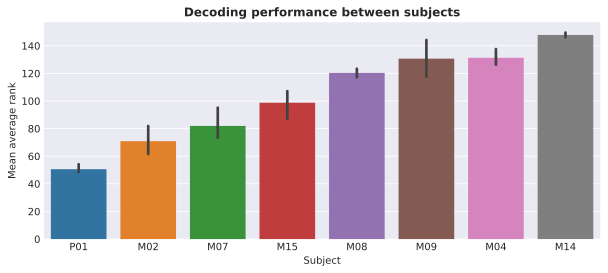

In [13]:
order = f_sub.groupby("subject").ridge.agg("mean").argsort()
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="subject", y="ridge", order=order.index[order], data=f_sub, ax=ax)
plt.xlabel("Subject")
plt.ylabel("Mean average rank")
plt.title("Decoding performance between subjects", weight="bold")

## Roger's analysis

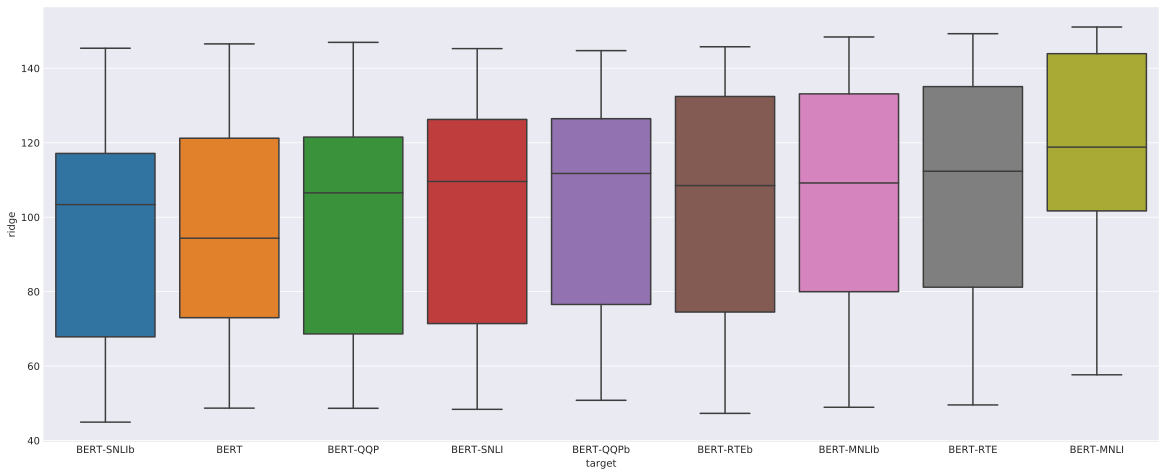

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))

target_order = f.groupby("target").ridge.agg("mean").argsort()
sns.boxplot(x="target", y="ridge", data=f, ax=ax, order=target_order.index[target_order])

In [15]:
f.groupby("target").ridge.agg("mean")

target
BERT           96.226190
BERT-MNLI     116.659061
BERT-MNLIb    105.709325
BERT-QQP       98.552249
BERT-QQPb     102.254960
BERT-RTE      107.514550
BERT-RTEb     103.292328
BERT-SNLI     101.234458
BERT-SNLIb     95.816138
Name: ridge, dtype: float64

[-0.4  0.6  1.6  2.6  3.6  4.6  5.6  6.6  7.6  0. ]


Text(0.87,-0.07,'* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test')

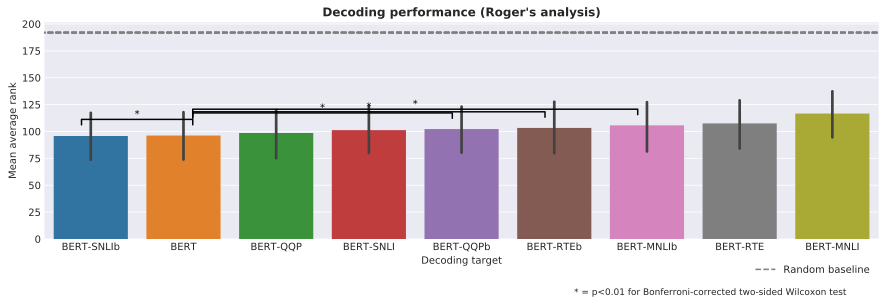

In [16]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance (Roger's analysis)", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.08))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
xticks = {label.get_text(): (pos, label) for pos, label in xticks}
mean_results = f.groupby("target").ridge.agg("mean")
# for (m1_pos, m1_label), (m2_pos, m2_label) in zip(xticks, xticks[1:]):
#     m1_label = m1_label.get_text()
#     m2_label = m2_label.get_text()
for m1, m2 in itertools.combinations(model_preds.keys(), 2):
    try:
        significant = wilcoxon_results.loc[m1, m2].significant_bonferroni
    except:
        try:
            significant = wilcoxon_results.loc[m2, m1].significant_bonferroni
        except:
            continue
            
    m1_pos, _ = xticks[m1]
    m2_pos, _ = xticks[m2]
    
    if significant:
        y = max(mean_results[m1], mean_results[m2]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.07, "* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)